In [17]:
%pylab inline

import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [18]:
from scipy import stats

In [43]:
def weyl_seq(n, step=np.sqrt(2), init=None):
    if not init:
        init = np.random.uniform()
    step = step % 1
    return ((init % 1) + step*np.arange(n)) % 1

class Normal:
    def __init__(self, mu=0.0, sigma=1.0, det=False):
        self.mu = mu
        self.sigma = sigma
        self.det = det
        
    def sample(self, n):
        if self.det:
            return self.det_samples(n)
        return self.stoch_samples(n)

    def det_samples(self, n):
        u_samples = weyl_seq(n)
        return stats.norm.ppf(u_samples, loc=self.mu, scale=self.sigma)

    def stoch_samples(self, n):
        return self.mu + self.sigma*np.random.normal(size=n)
    
    def log_pdf(self, x):
        return -(x-self.mu)**2/(2.0*self.sigma**2) - 0.5*np.log(2*np.pi) - np.log(self.sigma)

def SNIS(target_logp, proposal, n):
    samples = proposal.sample(n)
    weights = target_logp(samples) - proposal.log_pdf(samples)
    weights = np.exp(weights)
    weights = weights/np.sum(weights)
    mean = np.sum(samples*weights)
    variance = np.sum(weights*(samples - mean)**2)
    return mean, variance

def plot_errors(errors, n_iterations, label):
    errors_sorted = np.sort(errors, axis=0)
    plt.plot(n_iterations, np.mean(errors, axis=0), lw=5, label=label)
    plt.fill_between(n_iterations, errors_sorted[250,:], errors_sorted[750,:], alpha=0.3)
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('number of samples', fontsize=25)
    plt.ylabel('absolute error', fontsize=25)

In [20]:
def target_logp(x):
    component_1 = Normal(-2.0, 1.0)
    component_2 = Normal(2.0, 1.0)
    return np.log(0.5*np.exp(component_1.log_pdf(x)) + 0.5*np.exp(component_2.log_pdf(x)))

proposal_stoch = Normal(sigma=2.0)
proposal_det = Normal(sigma=2.0, det=True)

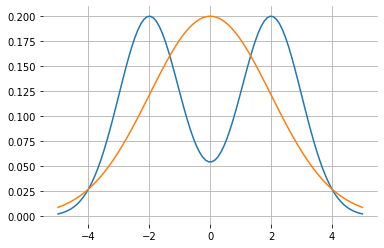

In [21]:
x = linspace(-5.0,5.0,100)
plt.plot(x,np.exp(target_logp(x)))
plt.plot(x,np.exp(proposal_stoch.log_pdf(x)))
plt.grid()
plt.box(False)

In [22]:
n_tries = 1000
sample_sizes = np.unique(np.logspace(0,4,30, dtype=int))
error_stoch = np.zeros([n_tries, len(sample_sizes)]) 
error_det = np.zeros([n_tries, len(sample_sizes)]) 
for i in range(n_tries):
    for j in range(len(sample_sizes)):
        mean_stoch, var_stoch = SNIS(target_logp, proposal_stoch, sample_sizes[j])
        mean_det, var_det = SNIS(target_logp, proposal_det, sample_sizes[j])
        error_stoch[i,j] = (mean_stoch)**2
        error_det[i,j] = (mean_det)**2

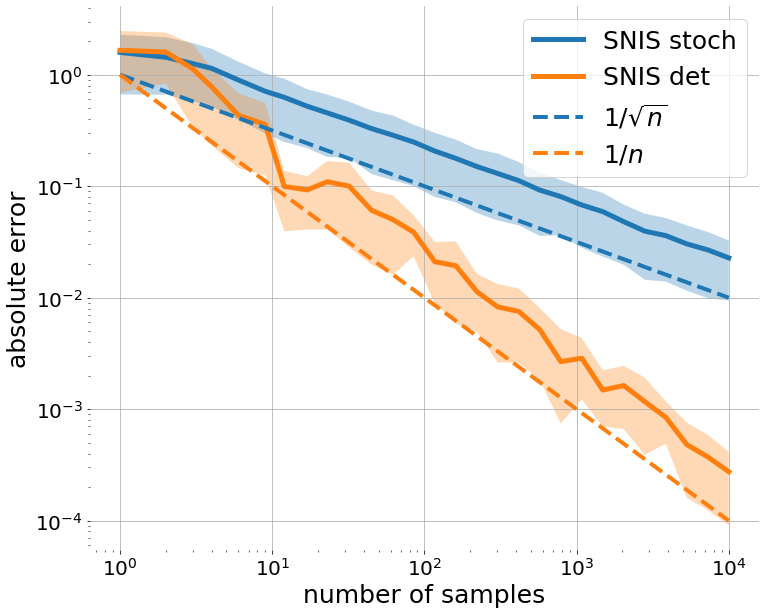

In [45]:
figsize(12,10)
palette = sns.color_palette()
plot_errors(np.sqrt(error_stoch), sample_sizes, label='SNIS stoch')
plot_errors(np.sqrt(error_det), sample_sizes, label='SNIS det')
plt.plot(sample_sizes, 1.0/np.sqrt(sample_sizes), color=palette[0], ls='--', lw=4, label=r'$1/\sqrt{n}$')
plt.plot(sample_sizes, 1.0/sample_sizes, color=palette[1], ls='--', lw=4, label=r'$1/n$')
plt.box(False)
plt.legend(fontsize=25)
plt.grid()
plt.savefig('SNIS.pdf', bbox_inches='tight')